# Project: Taxi orders forecast

## Getting the necessary libraries

In [1]:
!pip install pandas==1.5.3
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit,  train_test_split as tts, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error as mse 
import time
from math import sqrt

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from statsmodels.tsa.stattools import adfuller


     ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
     --------------------------------------- 0.0/10.3 MB 281.8 kB/s eta 0:00:37
      -------------------------------------- 0.2/10.3 MB 952.6 kB/s eta 0:00:11
     --- ------------------------------------ 1.0/10.3 MB 4.7 MB/s eta 0:00:02
     ----- ---------------------------------- 1.5/10.3 MB 6.4 MB/s eta 0:00:02
     -------------- ------------------------- 3.7/10.3 MB 12.3 MB/s eta 0:00:01
     ------------------------ --------------- 6.2/10.3 MB 18.1 MB/s eta 0:00:01
     ---------------------------------- ----- 8.9/10.3 MB 22.7 MB/s eta 0:00:01
     --------------------------------------  10.3/10.3 MB 36.3 MB/s eta 0:00:01
     --------------------------------------  10.3/10.3 MB 36.3 MB/s eta 0:00:01
     --------------------------------------  10.3/10.3 MB 36.3 MB/

## Importing the data

In [2]:
path1 = r'C:\Users\exeve\Downloads\taxi.csv'
path2 = '/datasets/taxi.csv'

try:
    if os.path.exists(path1):
        data = pd.read_csv(path1)
    elif os.path.exists(path2):
        data = pd.read_csv(path2)
except:
    print('Something went wrong')
        

## Checking the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data['datetime'] = data['datetime'].astype('datetime64')
data = data.set_index('datetime', drop = True)

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.index.is_monotonic_increasing

True

In [7]:
data = data.resample('1H').sum()

In [8]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [9]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


## Analysis

### Trend and Seasonality between March and August 2018

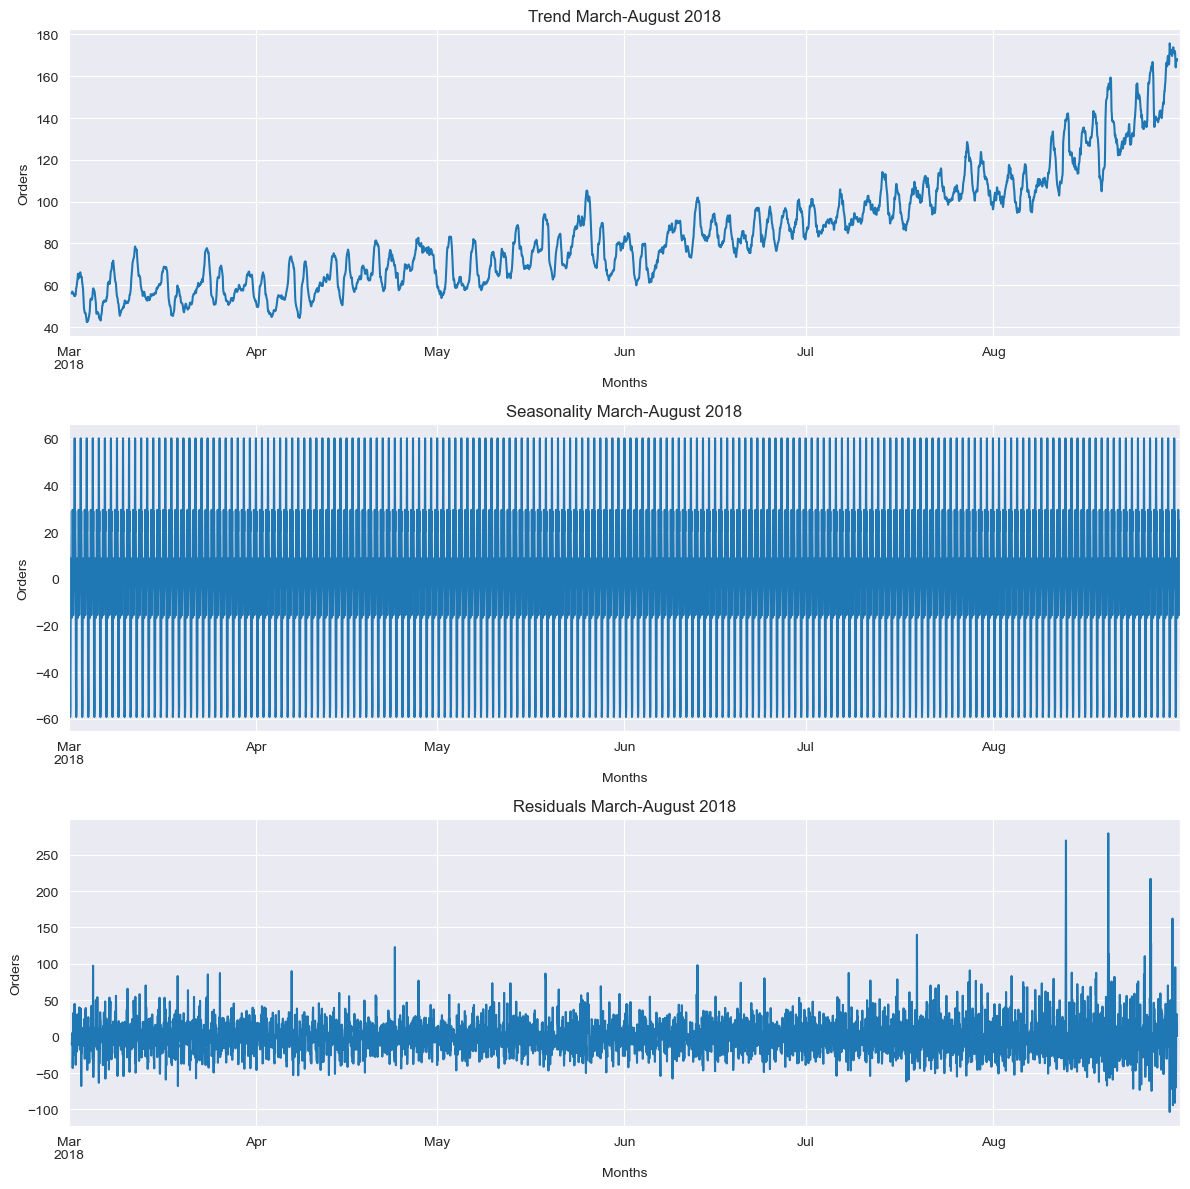

In [10]:
decomposed = seasonal_decompose(data)

sns.set_style('darkgrid')

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend March-August 2018')
plt.xlabel('Months')
plt.ylabel('Orders')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality March-August 2018')
plt.xlabel('Months')
plt.ylabel('Orders')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals March-August 2018')
plt.xlabel('Months')
plt.ylabel('Orders')

plt.tight_layout()

- Trend:
    - We can see the trend increasing as the year goes on. In August, the average number of orders is maximum.
- Seasonality:
    - The stochastic process is stationary. Its distribution does not change over time. The values fluctuate periodically. Thus, the increase and decrease of orders occurs every day in the same way, without major changes.

### Augmented Dickey-Fuller test

In [11]:
# Hypothesis 0: there is a unit root (non-stationary)
# Hypothesis 1: there is no unit root (stationary)

adfuller_results = adfuller(data['num_orders'])
pvalue = adfuller_results[1]
alpha = 0.05 # 5% significance level

print('\np-value:', round(pvalue, 3))

if pvalue > alpha:
    print('Null hypothesis is NOT REJECTED: Strong probability to be Non-stationary')
else:
    print('Null hypothesis is REJECTED: Strong probability to be STATIONARY')


p-value: 0.029
Null hypothesis is REJECTED: Strong probability to be STATIONARY


The test confirms that the distribution has a high probability of being stationary.

Let's look at one month separately, for example the one where there is a greater order trend:

### Trend and Seasonality in August 2018

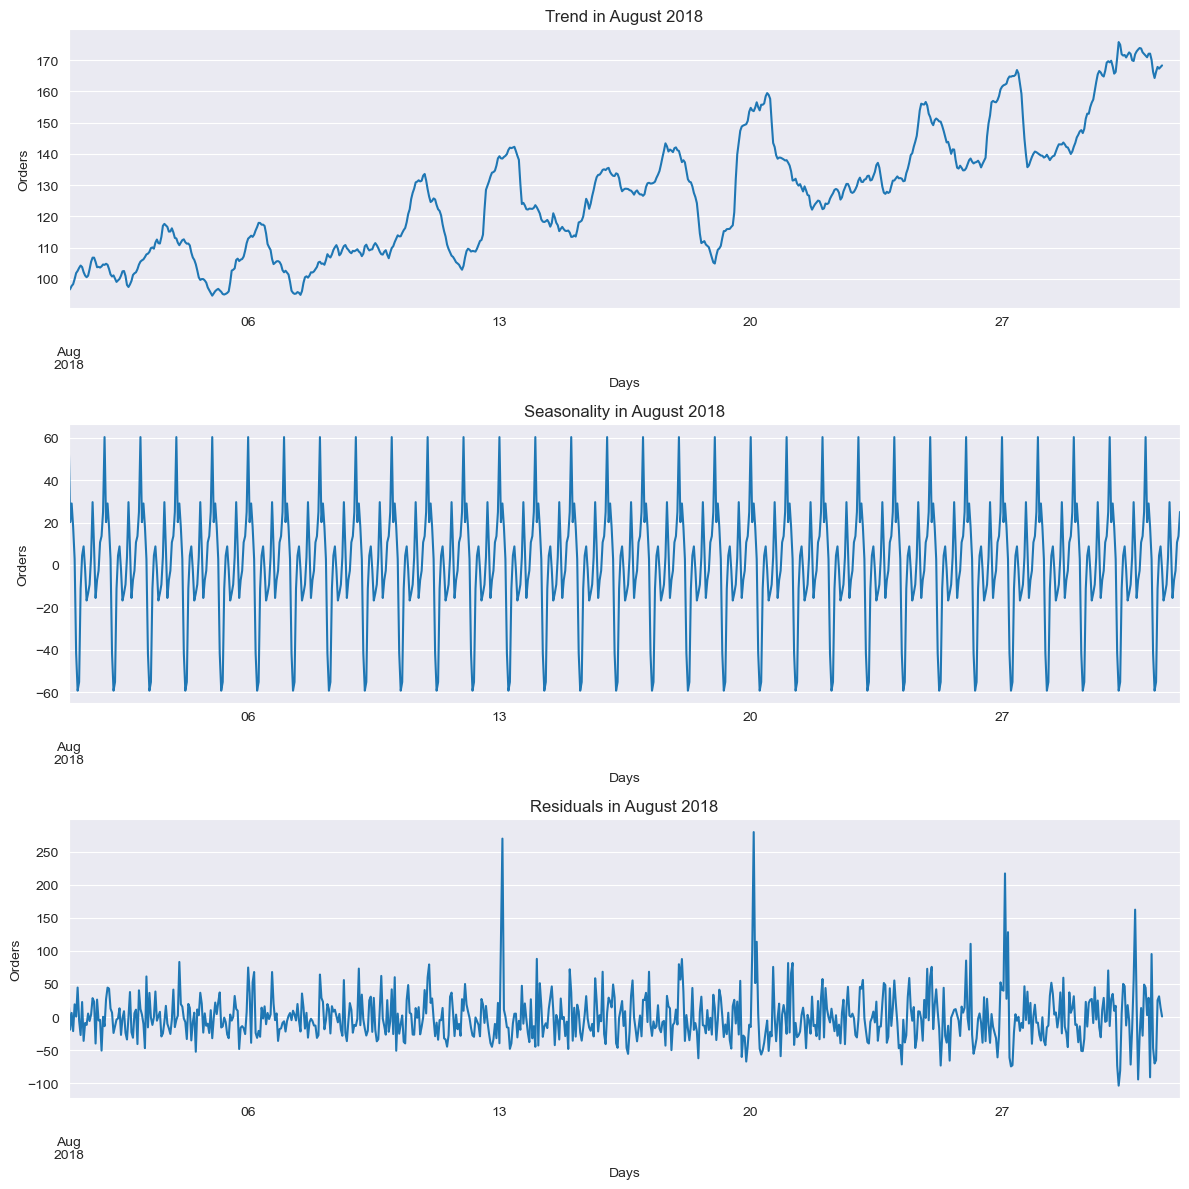

In [12]:
plt.figure(figsize=(12, 12))

sns.set_style('darkgrid')

plt.subplot(311)
decomposed.trend['2018-08'].plot(ax=plt.gca())
plt.title('Trend in August 2018')
plt.xlabel('Days')
plt.ylabel('Orders')

plt.subplot(312)
decomposed.seasonal['2018-08'].plot(ax=plt.gca())
plt.title('Seasonality in August 2018')
plt.xlabel('Days')
plt.ylabel('Orders')

plt.subplot(313)
decomposed.resid['2018-08'].plot(ax=plt.gca())
plt.title('Residuals in August 2018')
plt.xlabel('Days')
plt.ylabel('Orders')

plt.tight_layout()


- Trend:
    - We can see the trend increasing during the month. At the end of the month the average number of orders is maximum.
- Seasonality:
    - The stochastic process is stationary. Its distribution does not change over time. The values fluctuate periodically. Thus, the increase and decrease of orders occurs every day in the same way, without major changes.

### Augmented Dickey-Fuller test on data from August 2018

In [14]:
data_august = data['2018-08']

# Hypothesis 0: there is a unit root (non-stationary)
# Hypothesis 1: there is no unit root (stationary)

adfuller_results = adfuller(data_august['num_orders'])
pvalue = adfuller_results[1]
alpha = 0.05 # 5% significance level

print('\np-value:', round(pvalue, 3))

if pvalue > alpha:
    print('Null hypothesis is NOT REJECTED: Strong probability to be Non-stationary')
else:
    print('Null hypothesis is REJECTED: Strong probability to be STATIONARY')


p-value: 0.0
Null hypothesis is REJECTED: Strong probability to be STATIONARY


Everything is the same as in the general sample.

## Training

In this section, we will create a function to create the features that we will be used for prediction, and we will also create a GridSearchCV function that will give us the best parameters to select the best model. Then, we will check the Linear Regression, Ridge, Lasso and LightGBM models using this function.

### Prediction without a model
The predictions of our models should not be worse than the predictions without a model to be considered adequate.

#### Method 1: The new value x(t) is predicted by the previous value of the series, that is, x(t-1)

In [15]:
train, test = tts(data, shuffle=False, test_size=0.1)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

rmse_nomodel_1 =  mse(test['num_orders'], pred_previous) ** 0.5
print("RMSE without a model 1:", rmse_nomodel_1)



RMSE without a model 1: 58.856486242815066


#### Method 2: All test sample values are predicted by the same number (constant).

In [16]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
rmse_nomodel_2 = mse(test['num_orders'], pred_mean) ** 0.5
print("RMSE without a model 2:", rmse_nomodel_2 )

RMSE without a model 2: 84.74414402014742


### GridSearchCV Function

In [17]:
def grid(model, params, features, target):

    
    grid_search = GridSearchCV(model,
                      param_grid=params,
                      cv = TimeSeriesSplit(n_splits = 3),
                      scoring = 'neg_root_mean_squared_error',
                      n_jobs = -1,
                      verbose = 10
                    )
    
    
    grid_search.fit(features, target)
    
    
    
    
    return (grid_search.best_params_, grid_search.best_score_,
            grid_search.cv_results_['mean_fit_time'][grid_search.best_index_],
            grid_search.cv_results_['mean_score_time'][grid_search.best_index_])

### A function for feature creation

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    
    # calendar features
    data_mf = data.copy()
    data_mf['year'] = data_mf.index.year
    data_mf['month'] = data_mf.index.month
    data_mf['day'] = data_mf.index.day
    data_mf['dayofweek'] = data_mf.index.dayofweek
    data_mf['hour'] = data_mf.index.hour
    data_mf['minute'] = data_mf.index.minute
    data_mf['second'] = data_mf.index.second
    
    # Lagging values
    for lag in range(1, max_lag + 1):
        data_mf['lag_{}'.format(lag)] = data_mf['num_orders'].shift(lag)
        
    # Moving average
    data_mf['rolling_mean'] = data_mf['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_mf

The data we have goes from March to August (six months). 8 lags should be enough. On the other hand, the August 2018 trend chart shows sudden peaks every two days (every 48 hours) or so. Therefore, to smooth out these intervals in the time series, we will set rolling_mean_size = 48.

In [19]:
data = make_features(data = data, max_lag = 8, rolling_mean_size = 48)

### Getting train and test samples

In [20]:
train, test = tts(data, shuffle = False, test_size = 0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

### Linear Regression

In [21]:
lr = LinearRegression()

results_lr = cross_validate(lr,
                             X_train, y_train,
                             scoring = 'neg_root_mean_squared_error',
                             verbose = 10,
                             cv = TimeSeriesSplit(n_splits = 3))

lr_fit_time = results_lr['fit_time'].mean()
lr_score_time = results_lr['score_time'].mean()
lr_score = abs(results_lr['test_score'].mean())


print('Score:', lr_score, 
     '\nFitting time:', lr_fit_time,
     '\nScoring time:', lr_score_time)
     

[CV] START .....................................................................
[CV] END ....................................., score=-29.640 total time=   0.0s
[CV] START .....................................................................
[CV] END ....................................., score=-30.607 total time=   0.0s
[CV] START .....................................................................
[CV] END ....................................., score=-37.578 total time=   0.0s
Score: 32.60819322376907 
Fitting time: 0.009975115458170572 
Scoring time: 0.0033241907755533853


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


### Ridge Regression

In [22]:
ridge_params = {'alpha' : np.arange(0,1,0.2)}

results_ridge = grid(Ridge(random_state = 12345), ridge_params, X_train, y_train)


ridge_score = abs(results_ridge[1]), 
ridge_alpha = results_ridge[0]
ridge_fit_time = results_ridge[2]
ridge_score_time = results_ridge[3]

print('Score:', ridge_score,
     '\nalpha:', ridge_alpha,
     '\nFitting time:', ridge_fit_time,
     '\nScoring time:', ridge_score_time)
     


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Score: (32.608345300525464,) 
alpha: {'alpha': 0.2} 
Fitting time: 0.06218091646830241 
Scoring time: 0.006317138671875


### Lasso Regression

In [23]:
lasso_params = {'alpha' : np.arange(0,1,0.2)}

results_lasso = grid(Lasso(random_state = 12345), lasso_params, X_train, y_train)


lasso_score = abs(results_lasso[1]), 
lasso_alpha = results_lasso[0]
lasso_fit_time = results_lasso[2]
lasso_score_time = results_lasso[3]

print('Score:', lasso_score,
     '\nalpha:', lasso_alpha,
     '\nFitting time:', lasso_fit_time,
     '\nScoring time:', lasso_score_time)
     

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Score: (32.60819322376907,) 
alpha: {'alpha': 0.0} 
Fitting time: 0.16800586382548013 
Scoring time: 0.006648699442545573


### LightGBM

In [24]:
lgb_params = {'num_leaves' : range(31, 93, 30),
              'max_depth' : range(1,10,3),
              'learning_rate' : np.arange(0.1,1,0.3)}

results_lgb = grid(LGBMRegressor(random_state = 12345), lgb_params, X_train, y_train)

lgb_score = abs(results_lgb[1]), 
lgb_alpha = results_lgb[0]
lgb_fit_time = results_lgb[2]
lgb_score_time = results_lgb[3]

print('Score:', lgb_score,
     '\nalpha:', lgb_alpha,
     '\nFitting time:', lgb_fit_time,
     '\nScoring time:', lgb_score_time)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 3926, number of used features: 13
[LightGBM] [Info] Start training from score 78.516811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## Testing

### Choosing the best model

In [33]:
results_table = pd.DataFrame({'Model' : ['Ridge',
                                         'Lasso',
                                         'Linear Regression',
                                         'LGBM'],
                              
                              'RMSE' : [round(ridge_score[0],2),
                                       round(lasso_score[0], 2),
                                        round(lr_score, 2),
                                      round(lgb_score[0], 2)],
                              
                              
                              'Fitting Time': [round(ridge_fit_time, 2),
                                               round(lasso_fit_time, 2),
                                              round(lr_fit_time, 2), 
                                               round(lgb_fit_time, 2)],
                             })                                           

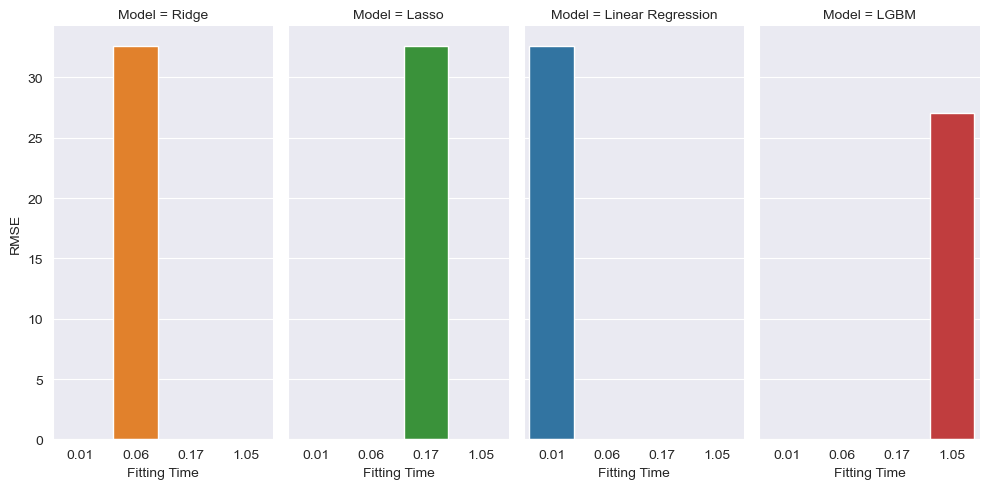

In [34]:
sns.catplot(data=results_table, x="Fitting Time", y="RMSE", col="Model", kind="bar", aspect=0.5 )
plt.show()

The accuracy of all models is almost the same, except LightGBM, which is slightly better, although slower.

### Testing the best model on the test sample

In [35]:
lgb_test = LGBMRegressor(random_state = 12345, max_depth = 7, num_leaves = 91)

fit_start = time.time()
lgb_test.fit(X_train, y_train)
fit_end = time.time()

pred_test_start = time.time()
pred_test = lgb_test.predict(X_test)
pred_test_end = time.time()

fitting_time = fit_end - fit_start
predicting_test_time = pred_test_end - pred_test_start

rmse_test = mse(y_test, pred_test) ** 0.5

print('RMSE on the TESTING sample:', rmse_test,
     '\nFitting time:', fitting_time,
     '\nPredicting testing sample time:', predicting_test_time)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 3926, number of used features: 13
[LightGBM] [Info] Start training from score 78.516811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

On the test sample, the best model gives an RMSE of 44.11, which is below the allowed limit (48).

### Comparison of the target with the predictions

In [36]:
compare = pd.concat([y_test, pd.Series(pred_test.astype(int), index = y_test.index, name = 'predictions')], axis = 1)
compare.sort_index()

,num_orders,predictions
datetime,,
2018-08-13 14:00:00,102,94
2018-08-13 15:00:00,175,113
2018-08-13 16:00:00,144,144
2018-08-13 17:00:00,152,134
2018-08-13 18:00:00,104,96
2018-08-13 19:00:00,91,90
2018-08-13 20:00:00,82,89
2018-08-13 21:00:00,160,118
2018-08-13 22:00:00,104,144


Text(0, 0.5, 'Orders')

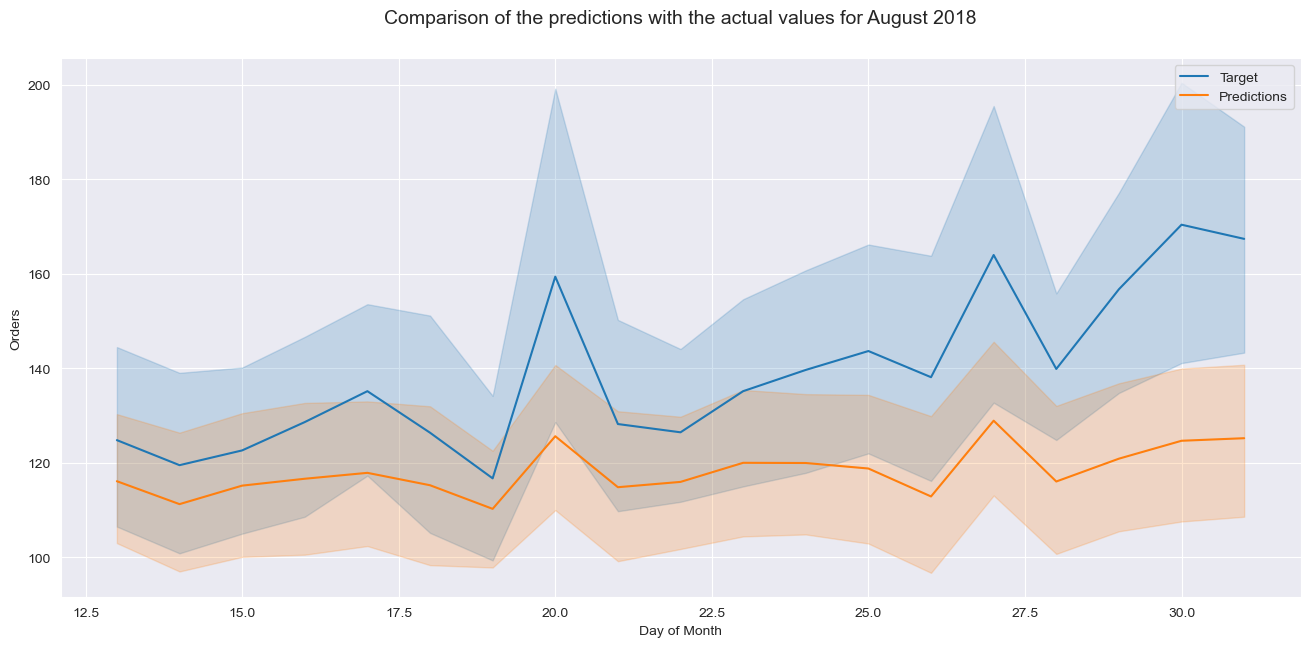

In [37]:
plt.figure(figsize=(16, 7))

plt.title('Comparison of the predictions with the actual values for August 2018', size = 14, y = 1.05)
sns.lineplot(x=compare.index.day, y=compare['num_orders'], label='Target')
sns.lineplot(x=compare.index.day, y=compare['predictions'], label='Predictions')

plt.xlabel('Day of Month')
plt.ylabel('Orders')

The graph shows that the predictions are generally quite accurate and are not very far from the actual values.

Let's see how things are going hour by hour, for example on the last day of August.

Text(0, 0.5, 'Orders')

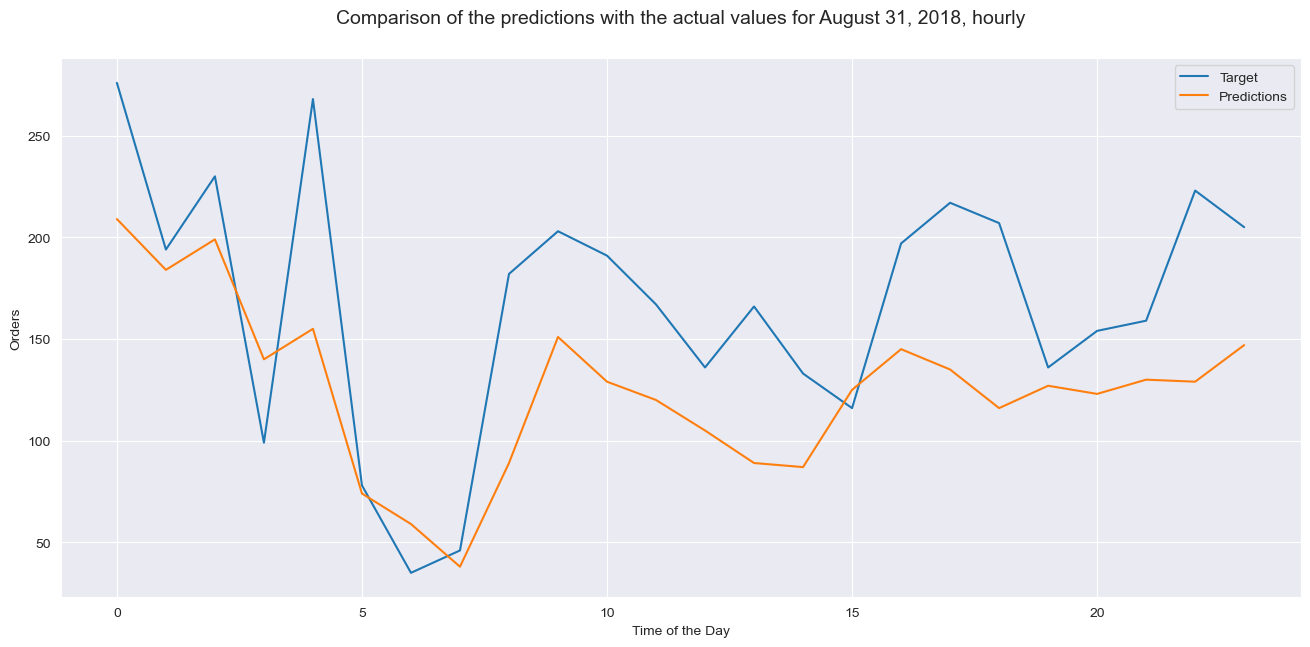

In [39]:
plt.figure(figsize=(16, 7))

compare_2 = compare['2018-08-31 00:00:00' :]

plt.title('Comparison of the predictions with the actual values for August 31, 2018, hourly', size = 14, y = 1.05)
sns.lineplot(x=compare_2.index.hour, y=compare_2['num_orders'], label='Target')
sns.lineplot(x=compare_2.index.hour, y=compare_2['predictions'], label='Predictions')

plt.xlabel('Time of the Day')
plt.ylabel('Orders')

Hourly forecasts are quite accurate, except for some periods from 00:00 to 05:00 am.

## Conclusion

- All models have very similar accuracy and outperform predictions without a model by at least 65 percent.
- However, the LGBMRegressor(random_state = 12345, max_depth = 7, num_leaves = 91) model was chosen as the best model because its accuracy is slightly better.
- In the end, we compared the values of targets and forecasts, and the model turns out to be quite accurate, excluding some rare unpredictable peaks in orders.